# [issue #6 Incorrect results](https://github.com/mshrtsr/fitting-rs/issues/6)

In [290]:
# install dependencies
!pip install numpy matplotlib scipy

You should consider upgrading via the '/Users/tasshi/.pyenv/versions/3.9.0/bin/python3.9 -m pip install --upgrade pip' command.


In [291]:
# imports
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.stats import norm
from fitting import gaussian
np.set_printoptions(precision=12, suppress=True)

## Phenomenon: Gaussian fit get wrong results for the test data

`fitting-rs` returns incorrect results.

### Results for the test data

range [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
test data [  446.   495.   549.   615.   694.  1087. 16012. 16476.  4815.  1318.
   777.   722.   714.   693.   681.   681.   668.   643.   606.   560.
   512.]
scipy.optimize.curve_fit [    6.576534508488     0.789437712434 19830.612248005185]
fitting-rs (guo's) [4.632651710220127, 4.438748232053301, 16683.674991852913]


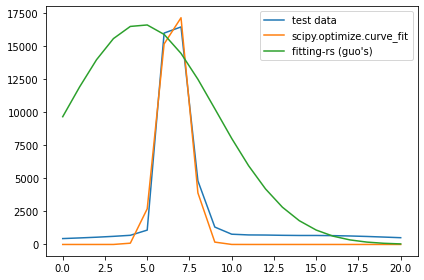

In [292]:
# range
x = np.arange(0., 21., 1)
print("range", x)

# test value
test_y = np.array([
    446.0, 495.0, 549.0, 615.0, 694.0, 1087.0, 16012.0, 16476.0, 4815.0, 1318.0,
    777.0, 722.0, 714.0, 693.0, 681.0, 681.0, 668.0, 643.0, 606.0, 560.0, 512.0
])
print("test data", test_y)

# answer from scipy.optimize.curve_fit
ans_scipy, _ = curve_fit(gaussian.val, x, test_y)
print("scipy.optimize.curve_fit", ans_scipy)

# answer from Guo's algorithm
ans_guos = gaussian.gaussian_fit_guos(x, test_y)
print("fitting-rs (guo's)",ans_guos)

# generate figure
fig, ax = plt.subplots()
ax.plot(x, test_y, label="test data")
ax.plot(x, gaussian.val(x, ans_scipy[0], ans_scipy[1], ans_scipy[2]), label="scipy.optimize.curve_fit")
ax.plot(x, gaussian.val(x, ans_guos[0], ans_guos[1], ans_guos[2]), label="fitting-rs (guo's)")

ax.legend(loc=0)
fig.tight_layout()
plt.show()

Results from `scripy.optimize.curve_fit`:

```
Fitted mean =  6.576534508488
Fitted standard deviation =  0.789437712434
Fitted a =  19830.612248005185
```

Results from `fitting-rs (guo's)`:

```
Fitted mean =  4.632651710220127
Fitted standard deviation =  4.438748232053301
Fitted a =  16683.674991852913
```

Fitted curve from `fitting-rs (guo's)` is significantly away from test data.

## Cause: Guo's algorithm deteriorates for a long tail GF

`fitting-rs::gaussian::fit` implemnts the Guo's algorithm.

Guo's algorithm is a gaussian fitting algorithm.  
It tries to find the true solution with non-interactive procedure.

cf. [I. Al-Nahhal, O. A. Dobre, E. Basar, C. Moloney and S. Ikki, "A Fast, Accurate, and Separable Method for Fitting a Gaussian Function [Tips & Tricks]," in IEEE Signal Processing Magazine, vol. 36, no. 6, pp. 157-163, Nov. 2019, doi: 10.1109/MSP.2019.2927685.](https://arxiv.org/pdf/1907.07241.pdf)

(`scripy.optimize.curve_fit` finds approximate solution with interactive procedure)

According to above paper, Guo's algorithm has low accuracy for long-tailed distribution.

## Solution 1: Slice the tail of test data

If possible, filtering the tail of test data is the easiest Solution.

### Results for short-tailed distribution (3 <= x < 11)

range [ 3.  4.  5.  6.  7.  8.  9. 10.]
test data [  615.   694.  1087. 16012. 16476.  4815.  1318.   777.]
scipy.optimize.curve_fit [    6.5765356297     0.7894371274 19830.6196954575]
caruana's [6.7450717016578565, 1.4848315873840416, 7423.0771085827]
guo's [6.482831955106326, 1.0970420200930318, 17738.39595086066]


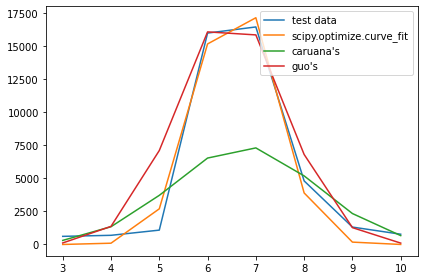

In [274]:
# slice range
start = 3
end = 11

# range
x = np.arange(0., 21., 1)
x = x[start:end]
print("range", x)

# test value
test_y = np.array([
    446.0, 495.0, 549.0, 615.0, 694.0, 1087.0, 16012.0, 16476.0, 4815.0, 1318.0,
    777.0, 722.0, 714.0, 693.0, 681.0, 681.0, 668.0, 643.0, 606.0, 560.0, 512.0
])
test_y = test_y[start:end]
print("test data", test_y)

# answer from scipy.optimize.curve_fit
ans_scipy, _ = curve_fit(gaussian.val, x, test_y)
print("scipy.optimize.curve_fit", ans_scipy)

# answer from Caruana's algorithm
ans_caruanas = gaussian.gaussian_fit_caruanas(x, test_y)
print("caruana's", ans_caruanas)

# answer from Guo's algorithm
ans_guos = gaussian.gaussian_fit_guos(x, test_y)
print("guo's",ans_guos)

# generate figure
fig, ax = plt.subplots()
ax.plot(x, test_y, label="test data")
ax.plot(x, gaussian.val(x, ans_scipy[0], ans_scipy[1], ans_scipy[2]), label="scipy.optimize.curve_fit")
ax.plot(x, gaussian.val(x, ans_caruanas[0], ans_caruanas[1], ans_caruanas[2]), label="caruana's")
ax.plot(x, gaussian.val(x, ans_guos[0], ans_guos[1], ans_guos[2]), label="guo's")

ax.legend(loc=0)
fig.tight_layout()
plt.show()

## Solution 2: Iterate Guo's algorithm

The paper introduces Guo's algorithm with iterative procedure , which can increase accuracy for long-tailed distribution.

However, iterative procedure wasn't efficient for given test data.


### Results with Guo's algorithm with iterative procedure

number of iteration: 100, 10000

range [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
test data [  446.   495.   549.   615.   694.  1087. 16012. 16476.  4815.  1318.
   777.   722.   714.   693.   681.   681.   668.   643.   606.   560.
   512.]
scipy.optimize.curve_fit [    6.5765345085     0.7894377124 19830.6122480052]
guo's [4.632651710220127, 4.438748232053301, 16683.674991852913]
guo's iterative (k=100) [4.6326517102201255, 4.438748232053626, 16683.674991851403]
guo's iterative (k=10000) [4.632651710239668, 4.438748232047389, 16683.674991781016]


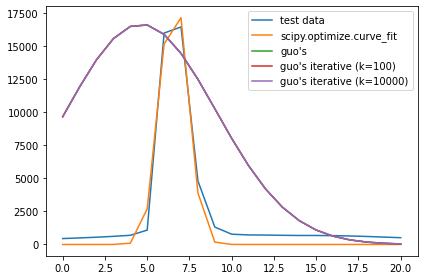

In [275]:
# range
x = np.arange(0., 21., 1)
print("range", x)

# test value
test_y = np.array([
    446.0, 495.0, 549.0, 615.0, 694.0, 1087.0, 16012.0, 16476.0, 4815.0, 1318.0,
    777.0, 722.0, 714.0, 693.0, 681.0, 681.0, 668.0, 643.0, 606.0, 560.0, 512.0
])
print("test data", test_y)

# answer from scipy.optimize.curve_fit
ans_scipy, _ = curve_fit(gaussian.val, x, test_y)
print("scipy.optimize.curve_fit", ans_scipy)

# answer from Guo's algorithm
ans_guos = gaussian.gaussian_fit_guos(x, test_y)
print("guo's",ans_guos)
ans_guos_iterative_100 = gaussian.gaussian_fit_guos_iterative_procedure(x, test_y, 100)
print("guo's iterative (k=100)", ans_guos_iterative_100)
ans_guos_iterative_10000 = gaussian.gaussian_fit_guos_iterative_procedure(x, test_y, 10000)
print("guo's iterative (k=10000)", ans_guos_iterative_10000)

# generate figure
fig, ax = plt.subplots()
ax.plot(x, test_y, label="test data")
ax.plot(x, gaussian.val(x, ans_scipy[0], ans_scipy[1], ans_scipy[2]), label="scipy.optimize.curve_fit")
ax.plot(x, gaussian.val(x, ans_guos[0], ans_guos[1], ans_guos[2]), label="guo's")
ax.plot(x, gaussian.val(x, ans_guos_iterative_100[0], ans_guos_iterative_100[1], ans_guos_iterative_100[2]), label="guo's iterative (k=100)")
ax.plot(x, gaussian.val(x, ans_guos_iterative_10000[0], ans_guos_iterative_10000[1], ans_guos_iterative_10000[2]), label="guo's iterative (k=10000)")

ax.legend(loc=0)
fig.tight_layout()
plt.show()

## Solution 3: Increase the test data

Generally the accuracy of fitting algorithm is depends on amount of test data.

### Results for twice amout of test data

range [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5]
test data [   42.0413475332    35.0511734593    17.6614331529    92.6444691075
    27.3999311322    17.6379426741    10.5240362907    43.6023713359
   140.1208316353   670.3596698681  2751.466525975   7833.5681090576
 15193.0737583056 19750.6761857466 17188.2978760121 10042.1807383399
  3908.1955062337  1052.7075702915   193.2331586335    31.3824502956
     8.0492949709    42.775489106     12.23048649      49.8044860964
    19.5313773617    29.9427301152    93.7976460651    23.2826229006
     2.6687303488    41.7511065593    38.0251558866    28.9320419412
     0.8048973518    32.298697015     51.1036760765    25.3402900068
    53.8432425685    51.5671032454    23.6348079253    14.8978990368
    13.4135381931    15.0061579874]
scipy.optimize.curve_fit [    6.5767972014  

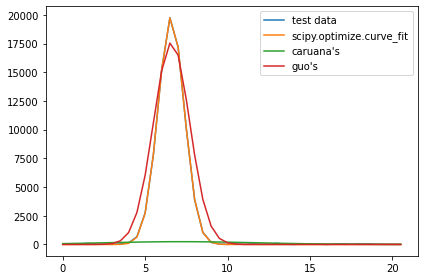

In [276]:
# range
x = np.arange(0., 21., 0.5)
print("range", x)

# test value
ans_true = [6.57653369889164, 0.7894414326527827, 19830.56343766285]
test_y = gaussian.val(x, ans_true[0], ans_true[1], ans_true[2]) + np.abs(np.random.normal(0, 50, len(x)))
print("test data", test_y)

# remove negative and zero value
x = x[test_y>0]
test_y = test_y[test_y>0]

# answer from scipy.optimize.curve_fit
ans_scipy, _ = curve_fit(gaussian.val, x, test_y)
print("scipy.optimize.curve_fit", ans_scipy)

# answer from Caruana's algorithm
ans_caruanas = gaussian.gaussian_fit_caruanas(x, test_y)
print("caruana's", ans_caruanas)

# answer from Guo's algorithm
ans_guos = gaussian.gaussian_fit_guos(x, test_y)
print("guo's",ans_guos)

# generate figure
fig, ax = plt.subplots()
ax.plot(x, test_y, label="test data")
ax.plot(x, gaussian.val(x, ans_scipy[0], ans_scipy[1], ans_scipy[2]), label="scipy.optimize.curve_fit")
ax.plot(x, gaussian.val(x, ans_caruanas[0], ans_caruanas[1], ans_caruanas[2]), label="caruana's")
ax.plot(x, gaussian.val(x, ans_guos[0], ans_guos[1], ans_guos[2]), label="guo's")

ax.legend(loc=0)
fig.tight_layout()
plt.show()

## Ex: Results in better condition

Despite high noise data, both Guo's and scipy got similar results.

range [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
20
test data [ 2  6  4  8 12 17 11 23 21 17 14 18  7 14  8  4  4  8  1  1]
scipy.optimize.curve_fit [ 8.2766977925  4.3718506747 18.6236249382]
caruana's [8.730727108755895, 4.584114631567854, 17.122134723632644]
guo's [8.540997995662911, 4.93702931652066, 19.396958411813046]


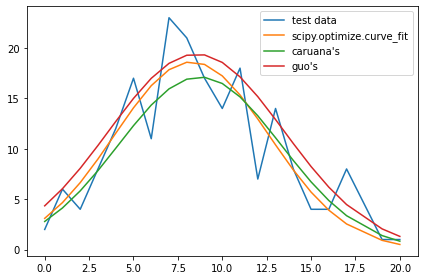

In [277]:
# range
samples = 20
x = np.array(np.arange(samples+1))
start = 0
end = 200
x = x[start:end]
print("range", x)

# test value
test_y = np.histogram(norm.rvs(loc=0, scale=1, size=samples*10), bins=samples+1)[0]
test_y = test_y[start:end]
# remove negative and zero value
x = x[test_y>0]
test_y = test_y[test_y>0]
print(len(test_y))
print("test data", test_y)

# answer from scipy.optimize.curve_fit
ans_scipy, _ = curve_fit(gaussian.val, x, test_y)
print("scipy.optimize.curve_fit", ans_scipy)

# answer from Caruana's algorithm
ans_caruanas = gaussian.gaussian_fit_caruanas(x, test_y)
print("caruana's", ans_caruanas)

# answer from Guo's algorithm
ans_guos = gaussian.gaussian_fit_guos(x, test_y)
print("guo's",ans_guos)

# generate figure
fig, ax = plt.subplots()
ax.plot(x, test_y, label="test data")
ax.plot(x, gaussian.val(x, ans_scipy[0], ans_scipy[1], ans_scipy[2]), label="scipy.optimize.curve_fit")
ax.plot(x, gaussian.val(x, ans_caruanas[0], ans_caruanas[1], ans_caruanas[2]), label="caruana's")
ax.plot(x, gaussian.val(x, ans_guos[0], ans_guos[1], ans_guos[2]), label="guo's")

ax.legend(loc=0)
fig.tight_layout()
plt.show()